## Predict the demand for bike share using known tools

Our goal is to predict demand for bike share based on [this](https://www.kaggle.com/c/bike-sharing-demand) Kaggle task.
Kaggle provides two data sets: a labelled train data and an unlabelled test data.
We have to use the train data to predict labels for the test data.
Kaggle won't give us the labels just a score we achieved on the test set.

### Know your data

In [1]:
import pandas as pd
import numpy as np

bike_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/bike_sample.csv")

In [2]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-10-18T03:00:00Z,4,0,1,1,18.04,21.970,94,6.0032,0,1,1
1,2011-08-17T21:00:00Z,3,0,1,1,29.52,34.090,62,15.0013,38,192,230
2,2012-11-11T11:00:00Z,4,0,0,1,18.86,22.725,59,8.9981,180,324,504
3,2011-05-12T16:00:00Z,2,0,1,2,26.24,31.060,57,16.9979,50,238,288
4,2011-05-04T15:00:00Z,2,0,1,1,19.68,23.485,51,27.9993,22,107,129


In [3]:
bike_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000
mean,2.536518,0.028939,0.684887,1.434084,20.249518,23.611169,62.011024,13.021061,36.555351,155.788700,192.344051
std,1.120364,0.167673,0.464667,0.642688,7.786268,8.444582,19.285464,8.150234,51.005170,151.047109,181.463651
min,1.000000,0.000000,0.000000,1.000000,0.820000,2.275000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,37.000000,44.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.000000,120.000000,147.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,224.000000,284.000000
max,4.000000,1.000000,1.000000,3.000000,41.000000,43.940000,100.000000,47.998800,362.000000,886.000000,977.000000


In [4]:
bike_data.shape

(2177, 12)

In [5]:
bike_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

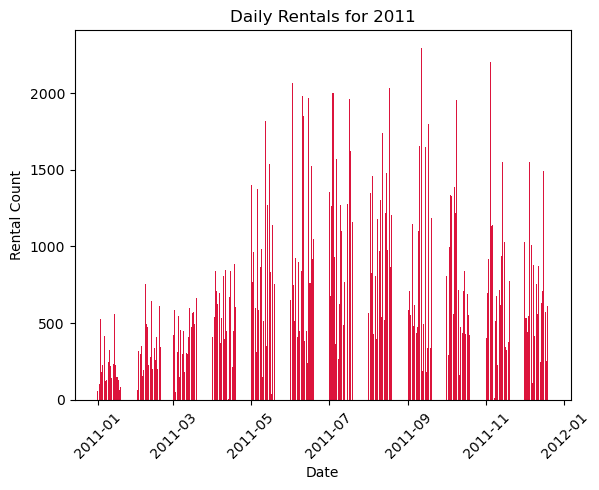

In [6]:
import matplotlib.pyplot as plt
bike_data["datetime"] = pd.to_datetime(bike_data["datetime"])
bike_2011 = bike_data[bike_data["datetime"].dt.year == 2011]
daily_counts = bike_2011.groupby(bike_2011["datetime"].dt.date)["count"].sum()
dates = daily_counts.index
counts = daily_counts.values

plt.bar(dates, counts, color="crimson")
plt.xlabel("Date")
plt.ylabel("Rental Count")
plt.title("Daily Rentals for 2011")
plt.xticks(rotation=45)
plt.show()

### Train-test split

In [7]:
# train-validation split on numeric features
from sklearn.model_selection import train_test_split

# keep numeric features
features = bike_data.drop(columns=["count"]).select_dtypes(include=np.number)
label = bike_data["count"]
np.random.seed(20240306)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

### Technical detour: best practice for pseudo random number generation and ensuring reproducibility

We used to ensure reproducibility by setting the global seed with `np.random.seed()`.

This is a risky practice as it modifies the global state. Some imported packages and functions may be unintentionally affected.

The recommended practice instead is to create a new (psuedo) random number generator and pass it around.
Call `np.random.RandomState(<seed>)` to create a new RNG.
(For numpy 1.17+, there is a statistically better alternative: `np.random.default_rng(<seed>)`. However, not all packages are already updated to accept that class as a random state.)

See more details [here](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

In [8]:
prng = np.random.RandomState(20240306)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)


### Evaluation function

In [36]:
def calculateRMSLE(prediction, y_obs):
    # Root Mean Squared Logarithmic Error (RMSLE)
    # np.sqrt: taking the square root
    # np.mean: taking the mean
    # np.log is taking the log
    # +1 is to avoid 0 logs
    # **2 is squaring the log values
    
    rmsle = np.sqrt(np.mean(
        ((np.log(np.where(prediction < 0, 0, prediction) + 1) - 
          np.log(y_obs + 1)
         ) ** 2)))
    return rmsle


### Benchmark

In [37]:
# estimate benchmark model
benchmark = np.mean(y_train)
benchmark_result = ["Benchmark", calculateRMSLE(benchmark, y_train), calculateRMSLE(benchmark, y_test)]

In [38]:
# collect results into a DataFrame
result_columns = ["Model", "Train", "Test"]
pd.DataFrame([benchmark_result], columns=result_columns)

,Model,Train,Test
0,Benchmark,1.561443,1.560975


Here, we can see that the train and test are quite similar, therefore this model is good with generalization. 



### Model #1: Simple Group averages

Insead of giving the same average everytime, we might give a different average by season, holiday, or workingday, etc. We can calculate a different average for different time series.

In [39]:
# model #1: group averages by season, holiday and workingday
from sklearn.linear_model import LinearRegression

features1 = ["season", "holiday", "workingday"]
feature_matrix1 = pd.get_dummies(X_train[features1], columns=features1, drop_first=True) # drops first column
# dropping column for the purpose of comparison to a certain season
# get_dummies function: creates two variables, one is x0 and then x1
feature_matrix1

,season_2,season_3,season_4,holiday_1,workingday_1
251,False,False,True,False,True
342,False,False,True,False,True
303,False,False,False,False,True
934,False,False,True,False,True
1334,False,False,False,False,True
...,...,...,...,...,...
2103,True,False,False,True,False
1776,False,False,True,False,False
729,True,False,False,False,True
1445,False,False,True,False,True


In [40]:
# evaluate model #1
group_avg = LinearRegression().fit(feature_matrix1, y_train)
train_error = calculateRMSLE(group_avg.predict(feature_matrix1), y_train)

# for test error we need to apply the same encoding on the test set
test_error = calculateRMSLE(group_avg.predict(pd.get_dummies(X_test[features1], columns=features1, drop_first=True)), y_test)
group_avg_result = ["Group-avg", train_error, test_error]
group_avg_result

['Group-avg', 1.516075731783048, 1.5111161063043004]

In [41]:
pd.DataFrame([benchmark_result, group_avg_result], columns=result_columns)

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116


### Technical detour: Using Pipelines from scikit-learn

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
steps = [
    ("dummify_selected_columns", ColumnTransformer([("dummify", one_hot_encoder, features1)])),
    ("ols", LinearRegression())
]
pipe_group_avg = Pipeline(steps)
pipe_group_avg

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday'])])),
                ('ols', LinearRegression())])

In [43]:
pipe_group_avg.fit(X_train, y_train)

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday'])])),
                ('ols', LinearRegression())])

In [44]:
pd.DataFrame({
    "feature": pipe_group_avg["dummify_selected_columns"].get_feature_names_out(),
    "coefficient": pipe_group_avg["ols"].coef_
})

,feature,coefficient
0,dummify__season_2,101.139374
1,dummify__season_3,116.483389
2,dummify__season_4,96.045344
3,dummify__holiday_1,6.210063
4,dummify__workingday_1,-3.569321


In [45]:
# Double-check we got the same result
[
    calculateRMSLE(pipe_group_avg.predict(X_train), y_train),
    calculateRMSLE(pipe_group_avg.predict(X_test), y_test)
]

[1.516075731783048, 1.5111161063043004]

In [58]:
columns = ['Model', 'Train Error', 'Test Error']
results = pd.DataFrame([benchmark_result, group_avg_result], columns=columns)

In [59]:
train_error = calculateRMSLE(pipe_group_avg.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_group_avg.predict(X_test), y_test)

lr1_model_result = ['Linear Regression 1', train_error, test_error]
results.loc[len(results)] = lr1_model_result
results

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116


### Model #2: Group averages with weather

In [60]:
# Model #2: Group averages with weather
dummy_features = ['season', 'holiday', 'workingday', 'weather']
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed']

steps = [
    ("dummify_selected_columns", ColumnTransformer([
        ("dummify", one_hot_encoder, dummy_features),
        ("keep", "passthrough", numeric_features)
    ])),
    ("ols", LinearRegression())
]

pipe_group_avg_with_weather = Pipeline(steps)
pipe_group_avg_with_weather

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('keep', 'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [61]:
pipe_group_avg_with_weather.fit(X_train, y_train)

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('keep', 'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [62]:
# Double-check we got the same result
[
    calculateRMSLE(pipe_group_avg_with_weather.predict(X_train), y_train),
    calculateRMSLE(pipe_group_avg_with_weather.predict(X_test), y_test)
]

[1.3949475274327485, 1.3825158298520086]

In [63]:
train_error = calculateRMSLE(pipe_group_avg_with_weather.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_group_avg_with_weather.predict(X_test), y_test)

lr2_model_result = ['Linear Regression 2', train_error, test_error]
results.loc[len(results)] = lr2_model_result
results

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516


### Model #3: Very flexible linear with polynomial features

In [64]:
from sklearn.preprocessing import PolynomialFeatures

steps = [
    ("dummify_selected_columns", ColumnTransformer([
        ("dummify", one_hot_encoder, dummy_features),
        ("keep", "passthrough", numeric_features)
    ])),
    ("4_degree_poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("ols", LinearRegression())
]
pipe_flexible_linear = Pipeline(steps)
pipe_flexible_linear

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('keep', 'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('4_degree_poly',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('ols', LinearRegression())])

In [65]:
pipe_flexible_linear.fit(X_train, y_train)
train_error = calculateRMSLE(pipe_flexible_linear.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_flexible_linear.predict(X_test), y_test)

flexible_linear_result = ['Flexible linear', train_error, test_error]
flexible_linear_result
results.loc[len(results)] = flexible_linear_result
results

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826


If we think about the fourth degree polinomial, we are going to have many hundreds of variables and it will be overly complex. So that is why our test error is higher than the previous models but the training error is smaller because it is overfitted. 

### Model #4: Improve with Lasso

Regularization helps us manage overfitting that we saw in the flexible lienar model. 

In [66]:
# Model #4: improve with Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler

steps = [
    ("dummify_selected_columns", ColumnTransformer([
        ("dummify", one_hot_encoder, dummy_features),
        ("scale", MinMaxScaler(), numeric_features)
    ])),
    ("4_degree_poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("lasso_regression", LassoCV(cv=5))
]
pipe_lasso = Pipeline(steps)
pipe_lasso

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('scale', MinMaxScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('4_degree_poly',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('lasso_regression', LassoCV(cv=5))])

In [67]:
pipe_lasso.fit(X_train, y_train)
train_error = calculateRMSLE(pipe_lasso.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_lasso.predict(X_test), y_test)

lasso_model_result = ['Flexible LASSO', train_error, test_error]
results.loc[len(results)] = lasso_model_result
results

C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5614.360041104257, tolerance: 4504.727965229887
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6905.431097287685, tolerance: 4504.727965229887
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4550.41011114046, tolerance: 4504.727965229887
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Con

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826
5,Flexible LASSO,1.305518,1.328260


### Model #5: Regression tree

In [68]:
from sklearn import tree

steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=5))
]
pipe_tree = Pipeline(steps)
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('tree', DecisionTreeRegressor(max_depth=5))])

In [69]:
pipe_tree.fit(X_train, y_train)

train_error = calculateRMSLE(pipe_tree.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_tree.predict(X_test), y_test)

tree_result = ['Tree', train_error, test_error]
results.loc[len(results)] = tree_result
results

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826
5,Flexible LASSO,1.305518,1.328260
6,Tree,0.207027,0.209803


In [73]:
#plt.figure(figsize=(12,12))
#tree.plot_tree(pipe_tree["tree"],feature_names=dummy_features + numeric_features)

## Improve the models

### Diagnostics

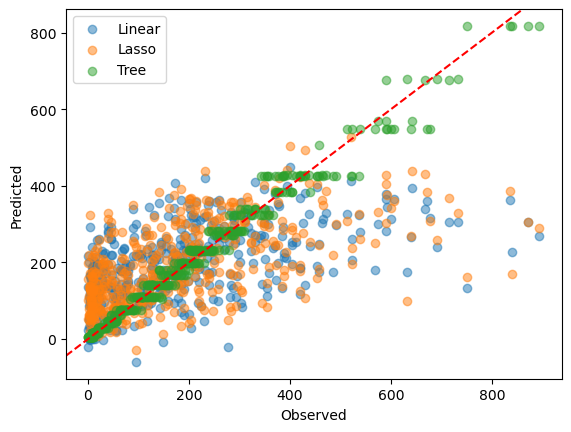

In [72]:
import matplotlib.pyplot as plt

linear_predictions = pipe_group_avg_with_weather.predict(X_test)
lasso_predictions = pipe_lasso.predict(X_test)
tree_predictions = pipe_tree.predict(X_test)

plt.scatter(y_test, linear_predictions, label='Linear', alpha=0.5)
plt.scatter(y_test, lasso_predictions, label='Lasso', alpha=0.5)
plt.scatter(y_test, tree_predictions, label='Tree', alpha=0.5)
plt.axline((1, 1), slope=1, linestyle='dashed', color='red')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend()

In [74]:
bike_data[bike_data['count'] < 10]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-10-18 03:00:00+00:00,4,0,1,1,18.04,21.970,94,6.0032,0,1,1
15,2012-09-12 03:00:00+00:00,3,0,1,1,20.50,24.240,77,6.0032,0,7,7
16,2011-01-06 02:00:00+00:00,1,0,1,1,6.56,11.365,64,0.0000,0,2,2
18,2011-01-04 00:00:00+00:00,1,0,1,1,6.56,9.090,55,7.0015,0,5,5
24,2011-04-14 03:00:00+00:00,2,0,1,1,13.94,16.665,81,8.9981,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2114,2011-03-18 03:00:00+00:00,1,0,1,1,14.76,17.425,71,12.9980,1,4,5
2123,2011-02-11 02:00:00+00:00,1,0,1,1,4.10,6.820,54,6.0032,0,3,3
2158,2011-12-18 05:00:00+00:00,4,0,0,1,8.20,11.365,59,7.0015,1,4,5
2160,2011-07-08 03:00:00+00:00,3,0,1,1,27.88,31.820,79,7.0015,2,4,6


### Feature engineering

In [75]:
def extract_dt_features(df_with_datetime):
    df_with_datetime['datetime'] = pd.to_datetime(df_with_datetime['datetime'], utc=True)
    df_with_datetime['year'] = df_with_datetime['datetime'].dt.year
    df_with_datetime['day'] = df_with_datetime['datetime'].dt.day
    df_with_datetime['month'] = df_with_datetime['datetime'].dt.month
    df_with_datetime['hour'] = df_with_datetime['datetime'].dt.hour
    df_with_datetime['dayofweek'] = df_with_datetime['datetime'].dt.dayofweek


extract_dt_features(bike_data)

In [76]:
feature_matrix = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)
label = bike_data["count"]
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.2, random_state=20240306)

In [77]:
dummy_features = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour', 'dayofweek']

steps = [
    ("dummify_selected_columns", ColumnTransformer([
        ("dummify", one_hot_encoder, dummy_features),
        ("keep", "passthrough", numeric_features)
    ])),
    ("ols", LinearRegression())
]
pipe_linear = Pipeline(steps)
pipe_linear.fit(X_train, y_train)

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather',
                                                   'year', 'month', 'day',
                                                   'hour', 'dayofweek']),
                                                 ('keep', 'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [78]:
train_error = calculateRMSLE(pipe_linear.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_linear.predict(X_test), y_test)

linear_FE_result = ['Feature engineered linear', train_error, test_error]
results.loc[len(results)] = linear_FE_result
results

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826
5,Flexible LASSO,1.305518,1.328260
6,Tree,0.207027,0.209803
7,Feature engineered linear,1.101936,1.191042


In [83]:
# TODO: LASSO

steps = [
    ("dummify_selected_columns", ColumnTransformer([
        ("dummify", one_hot_encoder, dummy_features),
        ("scale", MinMaxScaler(), numeric_features)
    ])),
    ("2_degree_poly", PolynomialFeatures(degree=2, include_bias=False)), #change to 1 degree to speed up the process
    ("lasso_regression", LassoCV(cv=5))
]
pipe_lasso = Pipeline(steps)
pipe_lasso.fit(X_train, y_train)

train_error = calculateRMSLE(pipe_lasso.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_lasso.predict(X_test), y_test)

lasso_model_result = ['Feature engineered LASSO', train_error, test_error]
results.loc[len(results)] = lasso_model_result
results

C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.734e+03, tolerance: 4.505e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.837e+03, tolerance: 4.505e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.039e+03, toleranc

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826
5,Flexible LASSO,1.305518,1.328260
6,Tree,0.207027,0.209803
7,Feature engineered linear,1.101936,1.191042
8,Feature engineered tree,0.609237,0.600795
9,Feature engineered LASSO,0.729800,0.915836


In [80]:
# TODO: Tree
tree_fe = tree.DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

train_error = calculateRMSLE(tree_fe.predict(X_train), y_train)
test_error = calculateRMSLE(tree_fe.predict(X_test), y_test)

tree_fe_result = ['Feature engineered tree', train_error, test_error]
results.loc[len(results)] = tree_fe_result
results

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826
5,Flexible LASSO,1.305518,1.328260
6,Tree,0.207027,0.209803
7,Feature engineered linear,1.101936,1.191042
8,Feature engineered tree,0.609237,0.600795


### Collect more data

In [84]:
bike_full = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/train.csv")
bike_full.shape

(10886, 12)

In [85]:
bike_data.shape

(2177, 17)

In [86]:
extract_dt_features(bike_full)

In [87]:
bike_full.shape

(10886, 17)

In [88]:
# Ensure the test set remains intact
full_data_without_original_test = bike_full.loc[~bike_full.datetime.isin(bike_data.filter(X_test.index, axis=0)['datetime'])]
full_data_without_original_test.shape

(10450, 17)

In [89]:
X_full = full_data_without_original_test.drop(columns=["count", "registered", "casual", "datetime"])
y_full = full_data_without_original_test['count']

In [90]:
# Linear

pipe_linear.fit(X_full, y_full)
train_error = calculateRMSLE(pipe_linear.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_linear.predict(X_test), y_test)

linear_FE_full_result = ['Feature engineered linear large n', train_error, test_error]
results.loc[len(results)] = linear_FE_full_result
results

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826
5,Flexible LASSO,1.305518,1.328260
6,Tree,0.207027,0.209803
7,Feature engineered linear,1.101936,1.191042
8,Feature engineered tree,0.609237,0.600795
9,Feature engineered LASSO,0.729800,0.915836


In [91]:
# Lasso
# TODO

pipe_lasso.fit(X_full, y_full)

train_error = calculateRMSLE(pipe_lasso.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_lasso.predict(X_test), y_test)

lasso_fe_full_result = ['Feature engineered LASSO large n', train_error, test_error]
results.loc[len(results)] = lasso_fe_full_result
results

C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35978.017426244915, tolerance: 29977.895663624407
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30265.753667891026, tolerance: 29723.588228409088
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23885.65399223566, tolerance: 23112.606521519145
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:66

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826
5,Flexible LASSO,1.305518,1.328260
6,Tree,0.207027,0.209803
7,Feature engineered linear,1.101936,1.191042
8,Feature engineered tree,0.609237,0.600795
9,Feature engineered LASSO,0.729800,0.915836


In [92]:
# Tree
# TODO

tree_fe = tree.DecisionTreeRegressor(max_depth=5).fit(X_full, y_full)

train_error = calculateRMSLE(tree_fe.predict(X_full), y_full)
test_error = calculateRMSLE(tree_fe.predict(X_test), y_test)

tree_fe_full_result = ['Feature engineered tree large n', train_error, test_error]
results.loc[len(results)] = tree_fe_full_result
results

,Model,Train Error,Test Error
0,Benchmark,1.561443,1.560975
1,Group-avg,1.516076,1.511116
2,Linear Regression 1,1.516076,1.511116
3,Linear Regression 2,1.394948,1.382516
4,Flexible linear,1.178129,1.759826
5,Flexible LASSO,1.305518,1.328260
6,Tree,0.207027,0.209803
7,Feature engineered linear,1.101936,1.191042
8,Feature engineered tree,0.609237,0.600795
9,Feature engineered LASSO,0.729800,0.915836


### Apply more flexible models

In [ ]:
# live coding

## Submit to Kaggle

In [ ]:
# live coding